# Train Policy and Deep QFunction from a heuristic QFunction

The action space of a 19x19 Gomoku board is immense. So it will be computationally expensive to explore also all those actions with smaller relevance. Having a heuristically-motivated function at hand - as we already have - we can do much better.

The goal of this section is to pre-train a deep convolutional network on arbitrary board states that don't even need to come in the correct sequence. The training goal is to mimic the heuristics for both the Q function $Q(s,a)$ and the Policy $\pi(s)$. Once there, it should be much easier, to efficiently explore the relevant action space.

Other researchers have gone similar paths:
- [Playing hard exploration games by watching YouTube](https://arxiv.org/abs/1805.11592)
- [Observe and Look Further: Achieving Consistent Performance on Atari](https://arxiv.org/abs/1805.11593)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import absolute_import, print_function, division
import numpy as np

In [3]:
A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U = \
    1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
BLACK=0
WHITE=1
EDGES=2
N=15

#### Creating training data

In [4]:
!ls /Users/wgiersche/GOMOKU_DATA/ # on my mac pro

ls: cannot access '/Users/wgiersche/GOMOKU_DATA/': No such file or directory


In [5]:
from wgomoku import GomokuBoard, GomokuTools as gt, Heuristics

In [6]:
h = Heuristics(kappa = 3.0)
board = GomokuBoard.from_csv("TreeSearchStudy.csv", h, disp_width=8, size=N)

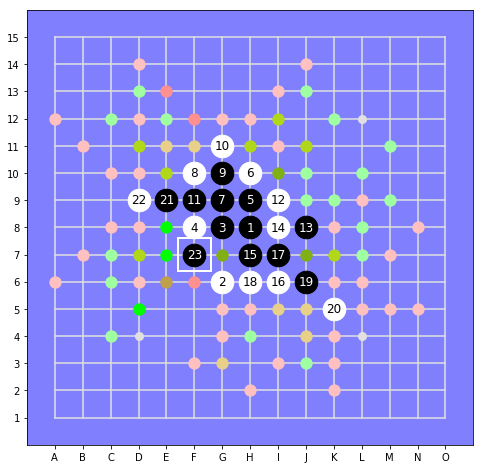

In [7]:
board.display(WHITE)

#### Creating a single sample

This function creates a *fenced* view on the board - a representation that can easily be digested by neural networks. From black viewpoint the board looks like it is surrounded by white stones. For white, it's the other way round. This allows a convolutional network to take the edges into account.

In [8]:
def create_sample(stones, N, viewpoint):
    
    sample = np.zeros([2, N, N], dtype=np.uint8)

    current = BLACK
    for move in stones:
        r,c=gt.b2m(move,N)
        sample[current][r][c]=1
        current = 1 - current
    
    offensive = np.hstack([
        np.zeros([N+2,1], dtype=np.uint8), 
        np.vstack([np.zeros(N, dtype=np.uint8), 
                   sample[viewpoint], 
                   np.zeros(N, dtype=np.uint8)]),
        np.zeros([N+2,1], dtype=np.uint8)
    ])
    
    defensive = np.hstack([
        np.ones([N+2,1], dtype=np.uint8), 
        np.vstack([np.ones(N, dtype=np.uint8), 
                   sample[1-viewpoint], 
                   np.ones(N, dtype=np.uint8)]),
        np.ones([N+2,1], dtype=np.uint8)
    ])
    both = np.array([offensive, defensive])
    return np.rollaxis(both, 0, 3)

We roll the channel axis to the front to have an easy-to-grasp idea of what the above function is doing

In [9]:
# view point is the next player, not the current
nextplayer = 1 - board.current_color
sample = create_sample(board.stones, N, 1 - board.current_color)
np.rollaxis(sample, 2,0)

array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 

---
### Heuristic labels for Q-functions

The ```heuristic_QF``` function uses our heuristic policy to estimate the value of any move $a$ from $s_t$ to $s_{t+1}$

In [10]:
# styles:
OFFENSIVE=0
DEFENSIVE=1
MIXED=2

In [11]:
from wgomoku import heuristic_QF, HeuristicGomokuPolicy

In [14]:
policy = HeuristicGomokuPolicy(style=MIXED, bias=0.5, topn=5)

In [15]:
board.undo(False).undo(False).undo(False).undo(False).undo()

In [16]:
q = heuristic_QF(board, policy)
q[0:10]

(array([[-200.        , -200.        , -200.        , -200.        ,
         -200.        , -200.        , -200.        , -200.        ,
         -200.        , -200.        , -200.        , -200.        ,
         -200.        , -200.        , -200.        ],
        [-200.        , -200.        , -200.        , -200.        ,
         -200.        , -200.        , -200.        , -200.        ,
         -200.        , -200.        , -200.        , -200.        ,
         -200.        , -200.        , -200.        ],
        [-200.        , -200.        , -200.        , -200.        ,
         -200.        , -200.        , -200.        , -200.        ,
         -200.        , -200.        , -200.        , -200.        ,
         -200.        , -200.        , -200.        ],
        [-200.        , -200.        , -200.        , -200.        ,
         -200.        , -200.        , -200.        , -200.        ,
         -200.        , -200.        , -200.        , -200.        ,
       

In [17]:
q_wrapped = np.hstack([
    np.zeros([N+2,1], dtype=np.float32), 
    np.vstack([np.zeros(N, dtype=np.float32), 
               q, 
               np.zeros(N, dtype=np.float32)]),
    np.zeros([N+2,1], dtype=np.float32)
])
q_wrapped.shape

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [55]:
sample.shape

(17, 17, 2)